<a href="https://colab.research.google.com/github/Nicohim87/DeepLearning-AOL/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [193]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("dionisiusdh/indonesian-batik-motifs")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /root/.cache/kagglehub/datasets/dionisiusdh/indonesian-batik-motifs/versions/1


In [194]:
img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, 'batik-kawung/1.jpg'), color_mode='grayscale')
img = tf.keras.utils.img_to_array(img)
img.shape

(1772, 1776, 1)

In [195]:
CHOSEN_CLASSNAME = ['batik-betawi', 'batik-kawung', 'batik-parang']
INPUT_SHAPE = (400, 400)

images = []
classes = []

In [196]:
for i, classname in enumerate(CHOSEN_CLASSNAME):
    for j, filename in enumerate(os.listdir(os.path.join(DATASET_PATH, classname))):
        img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, classname, filename), color_mode='grayscale', target_size=INPUT_SHAPE)
        img = tf.keras.utils.img_to_array(img)
        img = img/255
        images.append(img)
        classes.append(i)

In [197]:
images = np.array(images)
classes = np.array(classes)

In [198]:
y = tf.keras.utils.to_categorical(classes, num_classes=len(CHOSEN_CLASSNAME))
y.shape

(145, 3)

In [199]:
images.shape

(145, 400, 400, 1)

# **Train Test Splitting**

In [200]:
from sklearn.model_selection import train_test_split

In [201]:
x_train, x_temp, y_train, y_temp = train_test_split(images, y, test_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

[]

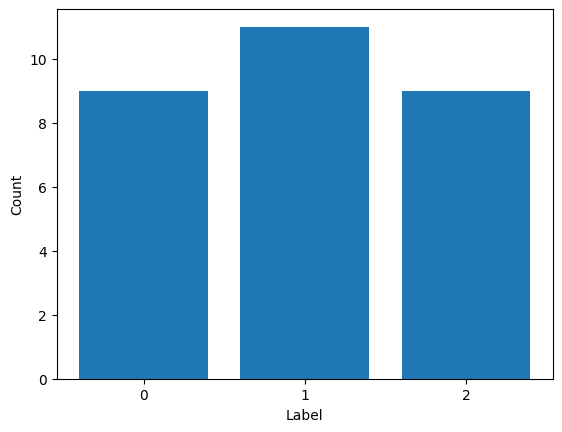

In [202]:
ylabel = [np.argmax(i) for i in y_train]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(label)
plt.plot()

# **Augmentation**

In [203]:
CLASS_SIZE = 50

In [204]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)  # Random vertical flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast
    image = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(image) # Random translation
    image = tf.keras.layers.RandomRotation(factor=0.5)(image)  # Random Rotation
    return image, label

def generate_data(x_train, y_train, size):
    # Convert to Tensor
    x_train = tf.convert_to_tensor(x_train)
    y_train = tf.convert_to_tensor(y_train)

    # Generate random indices
    indices = np.random.randint(0, len(x_train), size=size)

    # Apply augmentation
    x_train_generated = []
    y_train_generated = []
    for i in indices:
        x_gen, y_gen = augment_image(x_train[i], y_train[i])
        x_train_generated.append(x_gen)
        y_train_generated.append(y_gen)

    return x_train_generated, y_train_generated

In [205]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train_augmented = []
y_train_augmented = []
for i in range(len(CHOSEN_CLASSNAME)):
    indices = np.where(y_train[:, i] == 1)[0]

    x_aug, y_aug = generate_data(x_train[indices], y_train[indices], CLASS_SIZE)
    x_train_augmented.extend(x_aug)
    y_train_augmented.extend(y_aug)

In [206]:
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

permutation = np.random.permutation(len(x_train_augmented))

x_train_augmented = x_train_augmented[permutation]
y_train_augmented = y_train_augmented[permutation]

In [207]:
x_train_augmented.shape

(150, 400, 400, 1)

[]

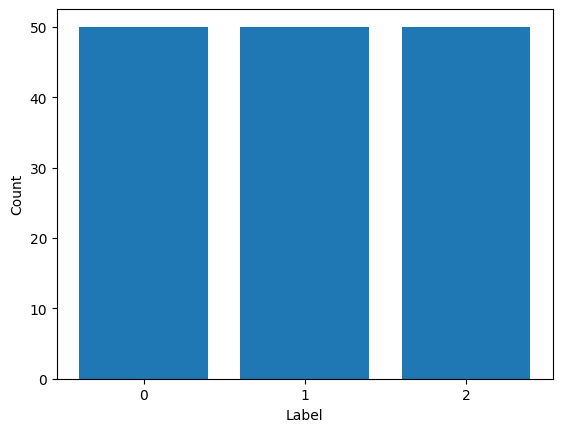

In [208]:
ylabel = [np.argmax(i) for i in y_train_augmented]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(label)
plt.plot()

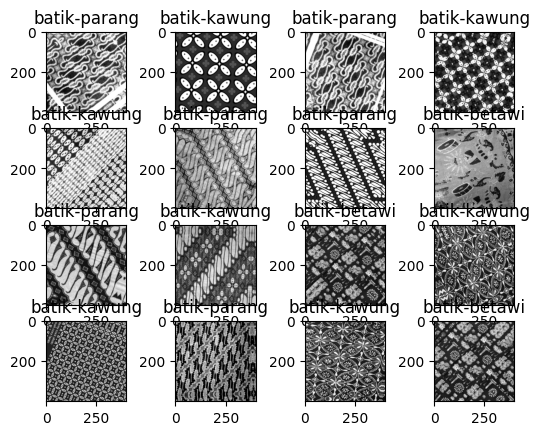

In [209]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train_augmented[i], cmap='gray')
    plt.title(CHOSEN_CLASSNAME[np.argmax(y_train_augmented[i])])

# **GAN**

In [210]:
import time
from IPython.display import clear_output

In [211]:
BUFFER_SIZE = 10000
BATCH_SIZE = 15

GAN_LEARNING_RATE = 1e-4

In [212]:
x_train = np.array(x_train)
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Generator

In [214]:
def generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input((100,)),
        tf.keras.layers.Dense(25*25*256, use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((25,25,256)),

        tf.keras.layers.Conv2DTranspose(128, kernel_size = (11, 11), strides = (4, 4), padding = 'same', use_bias = False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(64, kernel_size = (9, 9), strides = (2, 2), padding = 'same', use_bias = False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(32, kernel_size = (7, 7), strides = (2, 2), padding = 'same', use_bias = False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(16, kernel_size = (5, 5), strides = (1, 1), padding = 'same', use_bias = False, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2DTranspose(1, kernel_size = (5, 5), strides = (1, 1), padding = 'same', use_bias = False, activation='sigmoid')
    ])

    assert model.output_shape == (None, 400, 400, 1)

    return model

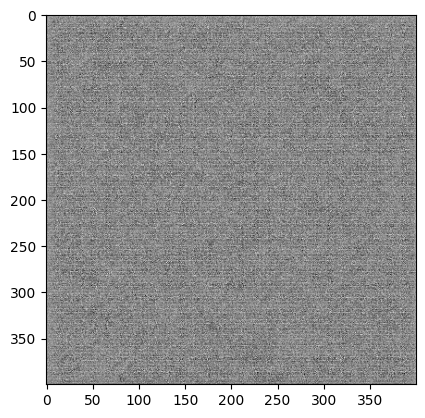

In [215]:
generator = generator_model()
noise = tf.random.normal([1,100])
generated_img = generator(noise, training=False)
plt.imshow(generated_img[0, :, :, 0], cmap='gray')

## Discriminator

In [216]:
def discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input((400, 400, 1)),
        tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same'),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same'),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),

        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [217]:
discriminator = discriminator_model()
confidence = discriminator(generated_img, training=False)
print(confidence)

tf.Tensor([[0.5130525]], shape=(1, 1), dtype=float32)


## Loss Function

In [218]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [219]:
def generator_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

In [220]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [221]:
generator_optimizer = tf.keras.optimizers.Adam(GAN_LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(GAN_LEARNING_RATE)

## GAN Training

In [222]:
EPOCHS = 250
NOISE_DIM = 100
NUM_EXAMPLE_TO_SHOW = 16

seed = tf.random.normal([NUM_EXAMPLE_TO_SHOW, NOISE_DIM])


In [223]:
@tf.function
def training(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_image, training=True)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)

    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_dis = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_dis, discriminator.trainable_variables))

    return gen_loss, dis_loss

In [224]:
def generate_images(model, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(5,5))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [225]:
def train(dataset, epochs):
    gen_losses = []
    dis_losses = []
    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = []
        epoch_dis_loss = []

        for i, batch in enumerate(dataset):
            gen_loss, dis_loss = training(batch)
            epoch_gen_loss.append(gen_loss)
            epoch_dis_loss.append(dis_loss)

        gen_loss_ = sum(epoch_gen_loss)/len(epoch_gen_loss)
        dis_loss_ = sum(epoch_dis_loss)/len(epoch_dis_loss)
        gen_losses.append(gen_loss_)
        dis_losses.append(dis_loss_)

        clear_output(wait=True)
        generate_images(generator, seed)

        print(f'Epoch {epoch+1} - {time.time()-start} seconds, loss = {gen_loss_ + dis_loss_}, gen_loss = {gen_loss_}, dis_loss = {dis_loss_}')

    clear_output(wait=True)
    generate_images(generator, seed)

    return gen_losses, dis_losses

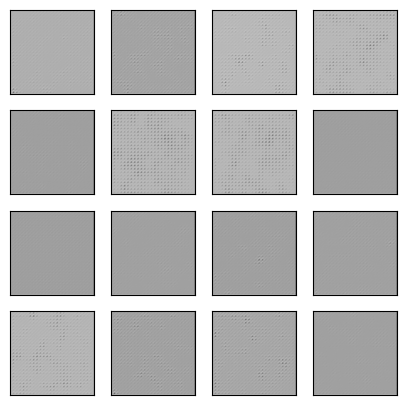

In [226]:
losses_g, losses_d = train(x_train, EPOCHS)

## GAN Metrics

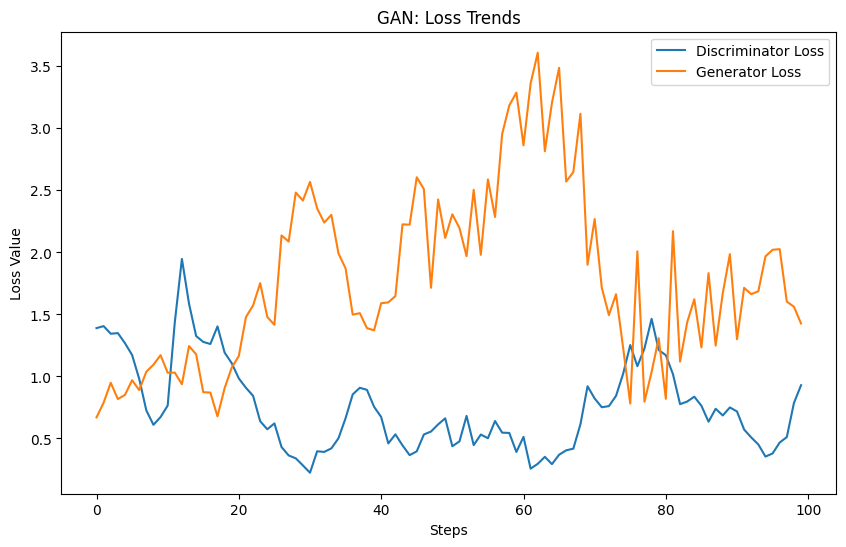

In [228]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()